In [1]:
import os
from types import FunctionType
import numpy as np
import pandas as pd
import scipy.linalg
from scipy.optimize import LinearConstraint
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

## Approximate Markov Chain

In [2]:
def get_gt(n_traj=10,n_state=3,len=10):
    p_gt = np.random.rand(n_state,n_state)       
    p_gt = (p_gt.T/p_gt.sum(axis=1)).T
    p_gt = np.where(np.isnan(p_gt), 0, p_gt)

    p = np.zeros([n_state,n_state])
    for i in range(n_state):
        for j in range(n_state):
            if j == 0:
                p[i,j] = p_gt[i,j]
            else:
                p[i,j] = p[i,j-1] + p_gt[i,j]

    # initial state
    traj = np.zeros([n_traj,len])
    for k in range(n_traj):
        s = np.random.randint(n_state)
        traj[k,0] = s + 1
        for i in range(1,len):      
            # print("p[k]", p[k])
            s = get_next_state(s,p)
            traj[k,i] = s + 1
            # if s != 0:
            #     counter += 1
    #         print(counter)
    return traj , p_gt

def get_p_k(n_traj=3,n_state=3,good_p_k=np.zeros([1,3,3]) ):
    n_good = len(good_p_k)
    print("n_good",n_good)
#     p = np.zeros([n_traj,n_state,n_state])
#   p: cdf   p_k:pdf
    p = np.zeros([n_traj+n_good,n_state,n_state])   
    p_k = np.zeros([n_traj+n_good,n_state,n_state])   
#     p_k = np.random.rand(n_traj+n_good,n_state,n_state)
    for k in range(n_traj):
        for i in range(n_state):
            for j in range(n_state):
                temp = np.random.rand()
                if temp > 0.5:
                    p_k[k,i,j] = 1
                else:
                    p_k[k,i,j] = 0
                if j == 0:
                    p[k,i,j] = p_k[k,i,j]
                else:
                    p[k,i,j] = p[k,i,j-1] + p_k[k,i,j]
            p[k,i,:] = p[k,i,:] / p[k,i,n_state-1] 
        p_k[k] = (p_k[k].T/p_k[k].sum(axis=1)).T
        p_k[k] = np.where(np.isnan(p_k[k]), 0, p_k[k])
        # print("p_gt",p_gt[k])
    p_k[-n_good:] = good_p_k

    return  p_k

def get_next_state(i,p):
    prob = np.random.rand()
    for j in range(len(p)):
        # print("p[i,j]",p[i,j])
        if prob < p[i,j]:
            return j
    return j



def get_p_bar(traj, n_state):
    # total = (len(traj[0])-1)
    p_bar = np.zeros([n_state,n_state])
    # print("traj[0]",len(traj))
    # print("traj[1]",len(traj[1]))
    for k in range(len(traj)):
        for i in range(len(traj[1])-1):
            p_bar[int(traj[k,i])-1,int(traj[k,i+1])-1] += 1
    p_bar = (p_bar.T/p_bar.sum(axis=1)).T
    p_bar = np.where(np.isnan(p_bar), 0, p_bar)
    return p_bar

def get_alpha(p_bar,p_k):
    n = len(p_k)
    # print("n",n)
    x0 = np.array([1/n]*n)
    # print("x0",x0)
    res = least_squares(fun, x0, bounds=(0, 1),args=(p_bar, p_k), verbose=1)
    alpha = res.x/sum(res.x)
    return alpha

def model(x, p_k):
    sum = 0
    for i in range(len(x)):
        sum += p_k[i]*x[i]
    return sum

def fun(x,p_bar,p_k):
    return sum((model(x, p_k) - p_bar)**2)

def get_p_hat(alpha,p_k):
    sum = 0
    for i in range(len(alpha)):
        sum += p_k[i]*alpha[i]
    return sum

def get_error(p_hat,Frobenius_gt):
    delta = p_hat - p_gt
#     print("delta",delta)
    Frobenius_delta = np.linalg.norm(delta)
    
#     print("Frobenius_gt",Frobenius_gt)
    error = Frobenius_delta/Frobenius_gt
    
    return error

        

In [8]:
# num of states
n = 10
traj, p_gt = get_gt(n_traj=1000,n_state=n,len=3000)
print("p_gt",p_gt)
Frobenius_gt = np.linalg.norm(p_gt)
print("Frobenius_gt",Frobenius_gt)
p_bar = get_p_bar(traj, n_state=n) 


p_gt [[0.12153968 0.16382632 0.08654196 0.07849075 0.20636182 0.10512102
  0.02204775 0.01689312 0.01045155 0.18872603]
 [0.03520643 0.05340354 0.15094324 0.01169795 0.15264212 0.12264824
  0.11393296 0.00484005 0.21450283 0.14018265]
 [0.0621557  0.07229602 0.09385573 0.17009464 0.17482032 0.1482024
  0.03497959 0.11529067 0.0026056  0.12569933]
 [0.17497995 0.07460752 0.12830594 0.02037506 0.13607443 0.0554963
  0.17370011 0.007174   0.05632573 0.17296096]
 [0.02416018 0.03980285 0.10640611 0.14385752 0.0705713  0.18033376
  0.09288616 0.0473332  0.18194864 0.11270028]
 [0.17030577 0.11127798 0.03541992 0.16031233 0.16265571 0.1259258
  0.04969973 0.09287797 0.05446637 0.03705842]
 [0.05834456 0.00072197 0.07286325 0.16482647 0.1164314  0.10221148
  0.05935872 0.17580525 0.14389094 0.10554596]
 [0.01380529 0.20395347 0.15247165 0.0786835  0.04968735 0.04956745
  0.03486486 0.15527072 0.16775993 0.0939358 ]
 [0.05272507 0.0793028  0.11240329 0.11379427 0.12970039 0.09523289
  0.127806

In [ ]:
# k_list = np.linspace(50, 200, 5, dtype=int,endpoint=True)
# k_list = [10,50,100,150,200,250,300]

error_list = []
# good_p_k = np.zeros([1,n,n]) 

n_good 35
`ftol` termination condition is satisfied.
Function evaluations 648, initial cost 4.0165e-03, final cost 4.1525e-04, first-order optimality 3.63e-08.
error 0.2652558386260711


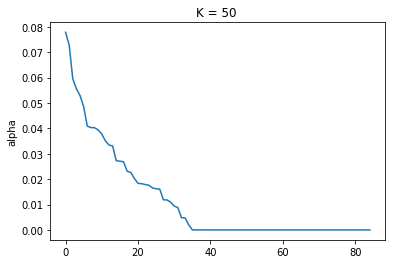

n_good 35


/home/cenyiliu/IRL/venv_2/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in true_divide
/home/cenyiliu/IRL/venv_2/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide


`ftol` termination condition is satisfied.
Function evaluations 752, initial cost 3.0009e-03, final cost 4.1525e-04, first-order optimality 5.23e-08.
error 0.2652821433961187


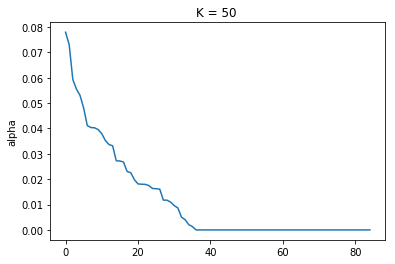

n_good 36
`ftol` termination condition is satisfied.
Function evaluations 1245, initial cost 3.0039e-03, final cost 4.1504e-04, first-order optimality 2.77e-08.
error 0.2652577235867158


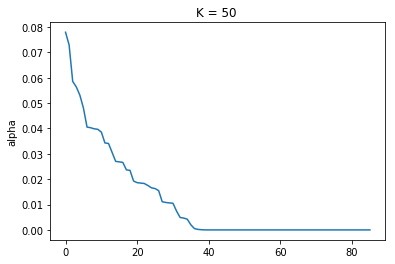

n_good 36
`ftol` termination condition is satisfied.
Function evaluations 543, initial cost 3.5517e-03, final cost 4.1502e-04, first-order optimality 3.70e-08.
error 0.2652443448585468


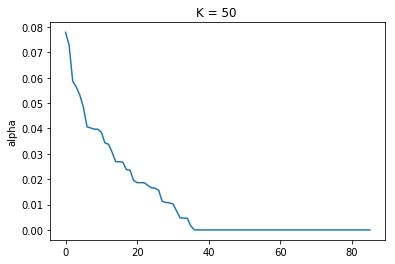

n_good 36
`ftol` termination condition is satisfied.
Function evaluations 695, initial cost 3.1830e-03, final cost 4.1469e-04, first-order optimality 4.37e-08.
error 0.2652489726967722


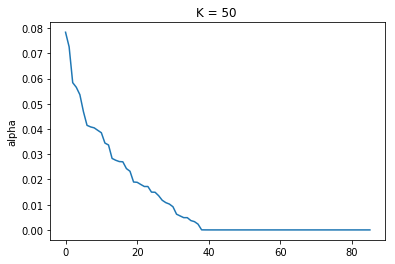

n_good 38
`ftol` termination condition is satisfied.
Function evaluations 672, initial cost 3.4362e-03, final cost 4.1453e-04, first-order optimality 3.04e-08.
error 0.2651554798180947


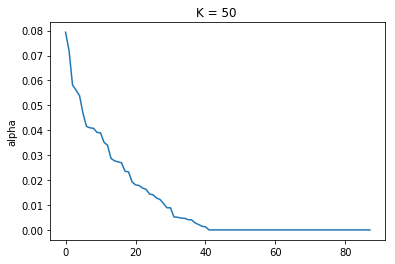

n_good 41
`ftol` termination condition is satisfied.
Function evaluations 1514, initial cost 3.6906e-03, final cost 3.9919e-04, first-order optimality 3.42e-08.
error 0.2629751704698432


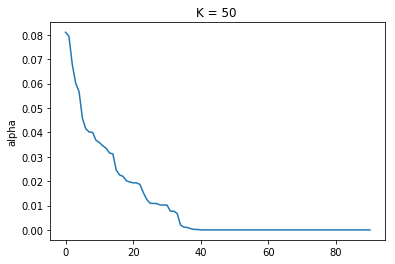

n_good 37
`ftol` termination condition is satisfied.
Function evaluations 704, initial cost 3.2384e-03, final cost 3.9598e-04, first-order optimality 1.21e-08.
error 0.2625759231581394


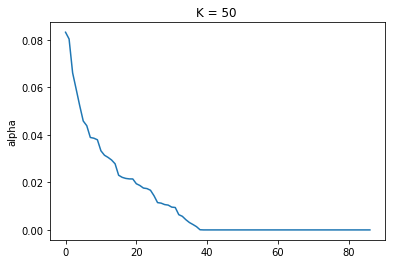

n_good 38
`ftol` termination condition is satisfied.
Function evaluations 602, initial cost 3.0562e-03, final cost 3.9287e-04, first-order optimality 4.07e-08.
error 0.2623132635767756


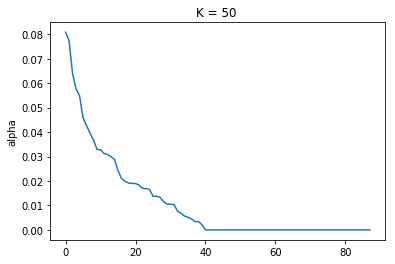

n_good 40
`ftol` termination condition is satisfied.
Function evaluations 511, initial cost 3.3840e-03, final cost 3.9287e-04, first-order optimality 5.42e-08.
error 0.2955406729443309


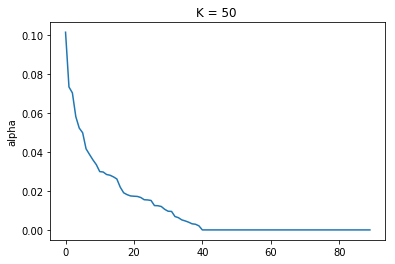

n_good 40
`ftol` termination condition is satisfied.
Function evaluations 1132, initial cost 3.2207e-03, final cost 3.8297e-04, first-order optimality 3.24e-08.
error 0.31165930565437405


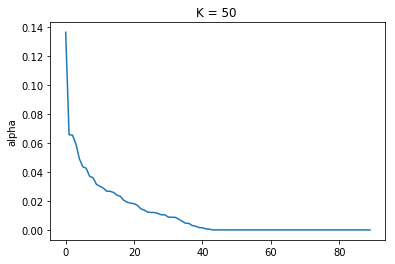

n_good 41
`ftol` termination condition is satisfied.
Function evaluations 1282, initial cost 2.9686e-03, final cost 3.7052e-04, first-order optimality 3.33e-08.
error 0.25858379102299933


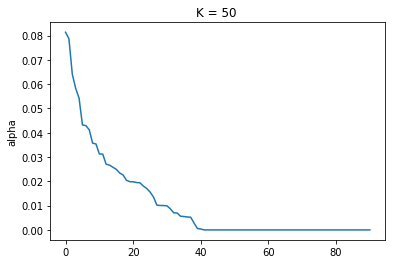

n_good 39
`ftol` termination condition is satisfied.
Function evaluations 483, initial cost 3.1827e-03, final cost 3.7049e-04, first-order optimality 1.87e-08.
error 0.2586466921242576


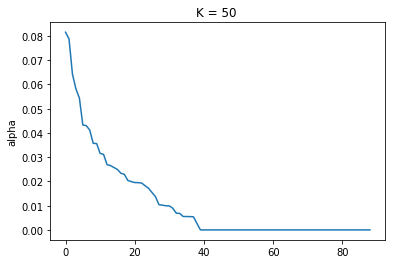

n_good 39
`ftol` termination condition is satisfied.
Function evaluations 587, initial cost 3.2321e-03, final cost 3.6954e-04, first-order optimality 3.17e-08.
error 0.258678445824204


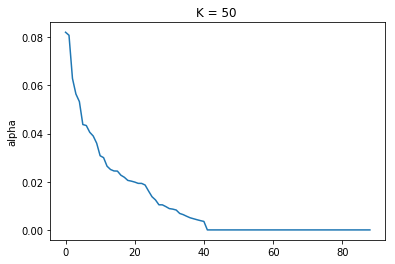

n_good 41
`ftol` termination condition is satisfied.
Function evaluations 1082, initial cost 3.0958e-03, final cost 3.6722e-04, first-order optimality 2.62e-08.
error 0.25863987882272416


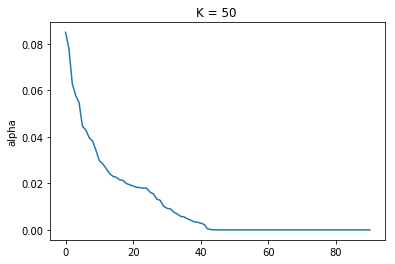

n_good 42
`ftol` termination condition is satisfied.
Function evaluations 1231, initial cost 2.5686e-03, final cost 3.6716e-04, first-order optimality 3.17e-08.
error 0.25860141846971024


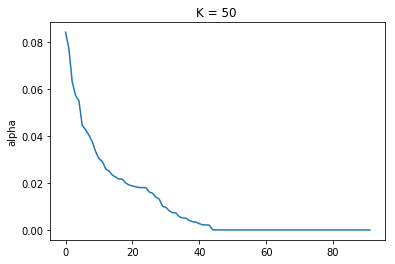

n_good 44
`ftol` termination condition is satisfied.
Function evaluations 1979, initial cost 2.6093e-03, final cost 3.5971e-04, first-order optimality 4.46e-08.
error 0.25735212505221194


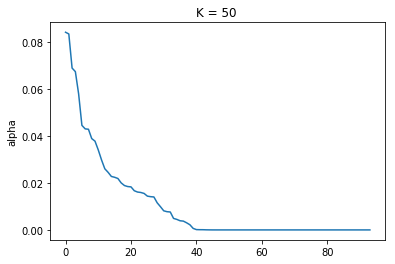

n_good 39
`gtol` termination condition is satisfied.
Function evaluations 622, initial cost 3.1507e-03, final cost 3.5969e-04, first-order optimality 9.69e-09.
error 0.2574879318733429


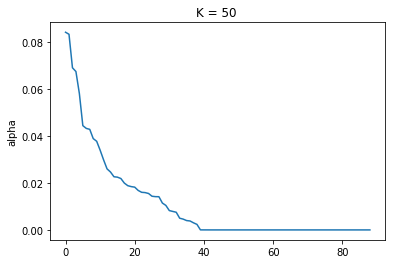

n_good 39
`ftol` termination condition is satisfied.
Function evaluations 880, initial cost 2.8710e-03, final cost 3.4062e-04, first-order optimality 4.62e-08.
error 0.2533238347077159


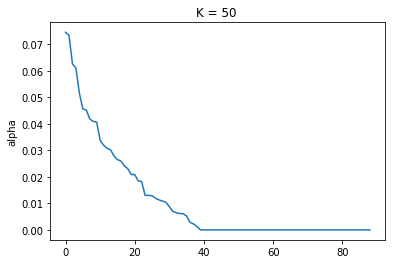

n_good 39
`ftol` termination condition is satisfied.
Function evaluations 1386, initial cost 3.0067e-03, final cost 3.3185e-04, first-order optimality 3.01e-08.
error 0.2856750150708324


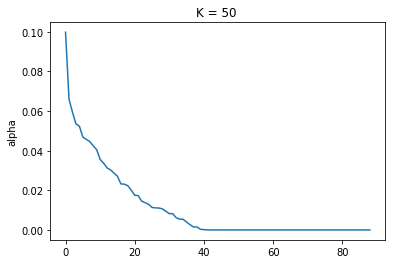

n_good 39
`ftol` termination condition is satisfied.
Function evaluations 936, initial cost 3.4325e-03, final cost 3.3184e-04, first-order optimality 4.43e-08.
error 0.25174538666608726


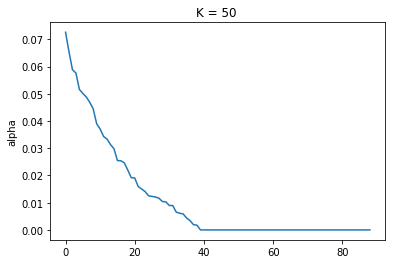

error_list [0.2847338495725803, 0.2828192056718304, 0.28281552993227027, 0.2780134772584661, 0.27178064599418783, 0.27189989690350874, 0.27190454390370605, 0.2710569215391924, 0.27114429204368934, 0.27114328349559524, 0.26906120919819765, 0.2690291347700695, 0.2690324483269315, 0.26902692646553483, 0.2690430682642765, 0.269016283071822, 0.26800687021137665, 0.26643983829684786, 0.2655308780890696, 0.26526255450760694, 0.2652538072869367, 0.2652558386260711, 0.2652821433961187, 0.2652577235867158, 0.2652443448585468, 0.2652489726967722, 0.2651554798180947, 0.2629751704698432, 0.2625759231581394, 0.2623132635767756, 0.2955406729443309, 0.31165930565437405, 0.25858379102299933, 0.2586466921242576, 0.258678445824204, 0.25863987882272416, 0.25860141846971024, 0.25735212505221194, 0.2574879318733429, 0.2533238347077159, 0.2856750150708324, 0.25174538666608726]


In [19]:
 for k in k_list:
    p_k = get_p_k(n_traj=k,n_state=n,good_p_k=good_p_k)
#     print(p_k)
    alpha = get_alpha(p_bar,p_k)
#     good_alpha = np.alpha(alpha > 0.03)
    good_p_k = p_k[alpha > 0.001]
#     print("good_p_k",good_p_k)
    p_hat = get_p_hat(alpha,p_k)
    error = get_error(p_hat,Frobenius_gt)
    print("error",error)
    error_list.append(error)
    
    # sort and print alpha
    sorted_alpha = np.sort(alpha)[::-1]
    plt.plot(sorted_alpha)
    plt.ylabel("alpha")
    plt.title("K = %i " % k)
    plt.show()
    
print("error_list",error_list)


In [67]:
while error > 0.1:
    p_k = get_p_k(n_traj=200,n_state=n,good_p_k=good_p_k)
#     print(p_k)
    alpha = get_alpha(p_bar,p_k)
#     good_alpha = np.alpha(alpha > 0.03)
    good_p_k = p_k[alpha > 0.000001]
#     print("good_p_k",good_p_k)
    p_hat = get_p_hat(alpha,p_k)
    error = get_error(p_hat,Frobenius_gt)
    print("error",error)
    error_list.append(error)
    
    # sort and print alpha
#     sorted_alpha = np.sort(alpha)[::-1]
#     plt.plot(sorted_alpha)
#     plt.ylabel("alpha")
#     plt.title("K = %i " % k)
#     plt.show()

n_good 80


KeyboardInterrupt: 

In [122]:
norm_error_list = []
for a in error_list:
    a = a/100
    norm_error_list.append(a)

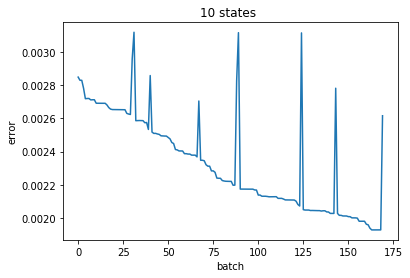

In [123]:
# plt.plot(k_list,error_list)

plt.plot(norm_error_list)
plt.xlabel("batch")
plt.ylabel("error")
plt.title("%i states " % n)
plt.show()

In [ ]:
p_k = get_p_k(n_traj=800,n_state=n)
alpha = get_alpha(p_bar,p_k)
p_hat = get_p_hat(alpha,p_k)
error = get_error(p_hat,Frobenius_gt)
print("error",error)

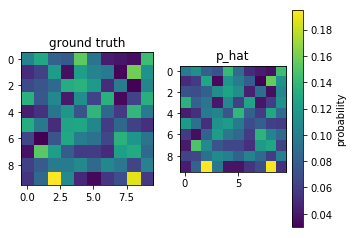

In [124]:
fig, (ax1,ax2) = plt.subplots(1,2)
im = ax1.imshow(p_gt)
ax1.set_title("ground truth")

im = ax2.imshow(p_hat)
ax2.set_title("p_hat")

fig.subplots_adjust(right=0.8)
fig.colorbar(im, label='probability')

plt.show()




best_p_k [[0.33333333 0.         0.         0.         0.33333333 0.
  0.33333333 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.        ]
 [0.         0.         0.2        0.         0.2        0.2
  0.2        0.2        0.         0.        ]
 [0.16666667 0.16666667 0.         0.         0.16666667 0.
  0.16666667 0.16666667 0.         0.16666667]
 [0.         0.16666667 0.16666667 0.16666667 0.         0.16666667
  0.         0.16666667 0.16666667 0.        ]
 [0.2        0.2        0.         0.2        0.         0.2
  0.2        0.         0.         0.        ]
 [0.33333333 0.         0.         0.         0.         0.
  0.33333333 0.         0.33333333 0.        ]
 [0.16666667 0.16666667 0.         0.         0.16666667 0.
  0.16666667 0.16666667 0.         0.16666667]
 [0.125      0.125      0.125      0.125      0.125      0.125
  0.125      0.125      0.         0.        ]
 [0.25       0.

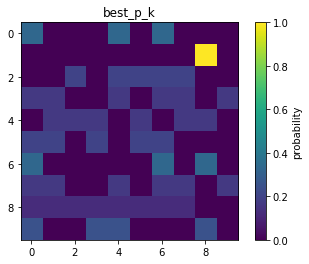

In [69]:
best_p_k = p_k[np.argmax(alpha)]
print("best_p_k",best_p_k)
print("p_gt",p_gt)
print("alpha",alpha[np.argmax(alpha)])
fig, ax = plt.subplots()
im = ax.imshow(best_p_k)
ax.set_title("best_p_k")

fig.colorbar(im, ax=ax, label='probability')

plt.show()

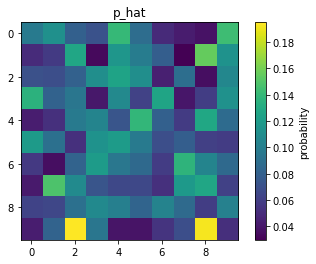

In [70]:
fig, ax = plt.subplots()
im = ax.imshow(p_hat)
ax.set_title("p_hat")

fig.colorbar(im, ax=ax, label='probability')

plt.show()

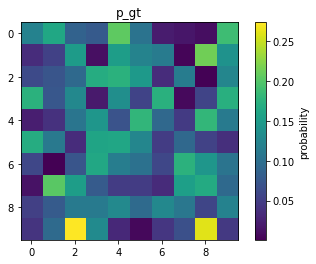

In [64]:
fig, ax = plt.subplots()
im = ax.imshow(p_gt)
ax.set_title("p_gt")

fig.colorbar(im, ax=ax, label='probability')

plt.show()

0.2717537641820097
90
usable percentage 0.9
p_diff [[1.97563409e-01 3.11057408e-01 7.41867911e-02 9.21248280e-02
  3.17925798e-01 1.53908580e-01 1.23806855e+00 1.50714167e+00
  2.60100851e+00 2.40062963e-01]
 [4.24088198e-01 7.86153131e-02 1.53865221e-01 1.90204133e+00
  2.34668093e-01 1.90671691e-01 3.06580464e-01 5.14382335e+00
  2.72280976e-01 1.87496302e-01]
 [1.42008475e-01 4.18827881e-02 1.34559652e-01 3.44925596e-01
  2.81084436e-01 2.47687266e-01 2.60790010e-01 2.25273618e-01
  1.27924328e+01 1.54526446e-01]
 [2.22094388e-01 9.75315507e-02 2.62802410e-01 9.88985369e-01
  2.09511422e-01 1.28674952e-01 2.71476880e-01 4.56584646e+00
  6.30605900e-02 3.43104168e-01]
 [7.89157370e-01 3.18726509e-01 8.64469558e-02 2.76021009e-01
  3.82253745e-02 2.28519905e-01 1.34528605e-01 2.35576868e-01
  2.94706156e-01 2.23079638e-01]
 [2.96080754e-01 1.84410203e-01 4.85070265e-01 2.87033094e-01
  2.60833866e-01 2.22966298e-01 3.94625693e-01 1.45333414e-01
  1.18183332e-01 5.92493305e-01]
 [2.463

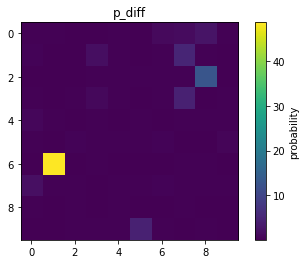

In [131]:
p_diff = np.sqrt(((p_gt - p_hat)/p_gt)**2)
# p_abs = np.abs((p_gt - p_hat)/p_gt)
counter = 0
s = 0
for row in p_diff:
    for p in row:
        if p < 1:
            counter += 1
            s  += p**2
            
e= np.sqrt(s/counter)
print(e)
print(counter)
print("usable percentage",counter/n**2)            


# m = np.average(p_diff)
# q = np.linalg.norm(p_diff)
print("p_diff",p_diff)
# print("p_abs",p_abs)

fig, ax = plt.subplots()
im = ax.imshow(p_diff)
ax.set_title("p_diff")

fig.colorbar(im, ax=ax, label='probability')

plt.show()

## Approximate MDP

In [ ]:
def get_mdp_gt(n_traj=10,n_state=3,n_action=3,len=10):
    p_gt = np.random.rand(n_state,n_state*n_action)       
    p_gt = (p_gt.T/p_gt.sum(axis=1)).T
    p_gt = np.where(np.isnan(p_gt), 0, p_gt)

    p = np.zeros([n_state,n_state])
    for i in range(n_state):
        for j in range(n_state):
            if j == 0:
                p[i,j] = p_gt[i,j]
            else:
                p[i,j] = p[i,j-1] + p_gt[i,j]

    # initial state
    traj = np.zeros([n_traj,len,2])
    for k in range(n_traj):
        s = np.random.randint(n_state)
        a = np.random.randint(n_action)
        traj[k,0] = [s + 1, a]
        for i in range(1,len):      
            # print("p[k]", p[k])
            s = get_next_mdp_state(s,a,p)
            traj[k,i] = [s + 1,a]
            # if s != 0:
            #     counter += 1
    #         print(counter)
    return traj , p_gt

def get_next_mdp_state(i,a,p):
    prob = np.random.rand()
    for j in range(len(p)):
        # print("p[i,j]",p[i,j])
        print((j-1)*3+a-1)
        if prob < p[i,(j-1)*3+a-1]:
            return j
    return j